In [1]:
import matplotlib.pyplot as plt
from matplotlib import transforms
from matplotlib import rc
from IPython.display import Image
import numpy as np
from astropy.io import fits as pyfits
from astropy.io import fits
from scipy.ndimage import gaussian_filter
import scipy
from scipy.optimize import minimize, rosen, rosen_der
from scipy.special import factorial
import scipy.integrate as integrate
from scipy.integrate import quad
from itertools import starmap
from scipy import optimize
import corner
import time
from mpl_toolkits import mplot3d
import healpy as hp
from scipy import nan
import math

In [2]:
def nfw_profile_density(r, gamma = 1):
    #need to eventually normalize to local density (4 GeV/cm^2)
    #also normalize to fraction of DM in black holes
    r_s = 20 #kpc
    #make sure r is in kpc
    #rho_0 = get_rho0(massBH, gamma_forrho0 = gamma)
    rho_0 = get_rho0() #GeV/cm^3
    rho = rho_0/(r/r_s)**(gamma)/((1+r/r_s)**(3-gamma)) #.4 GeV/cm^3
    return rho

def get_rho0(gamma_forrho0 = 1):
    #calculating the initial rho_0
    r = 8.25 #kpc
    R_s = 20 #kpc
    rho_NFW = 0.4 #BHs/cm^3, should be BHs/cm^3
    rho_0 = (r/R_s)**(gamma_forrho0)*rho_NFW*(1+r/R_s)**(3-gamma_forrho0)
    #print('rho_0: {}'.format(rho_0))
    #rho_0 = .257
    return rho_0

In [3]:
def i_hate_trig(theta, l):
    R_GC = 8.25 #kpc
    theta_radians = theta/180*np.pi

    r = np.sqrt(l**2+R_GC**2-2*l*R_GC*math.cos(theta_radians))

    #B = np.arcsin(l*np.sin(theta)/r)
    #phi = 180-theta-B
    
    return r
    
    
def range_over_l(theta, gamma_here = 1):
    l = np.linspace(1, 60, 10000) #in kpc
    r = i_hate_trig(theta, l)
    #print(r)

    density = nfw_profile_density(r, gamma = gamma_here)
    #print(density)

    
    return l, density

In [12]:
def get_long_lat(longlatboo = True):

    filelist = ['Bremss_00320087_E_50-814008_MeV_healpix_128.fits', 'Bremss_SL_Z6_R20_T100000_C5_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_A_E_50-814008_MeV_healpix_128.fits', 'pi0_Model_F_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_A_E_50-814008_MeV_healpix_128.fits', 'ICS_Model_F_E_50-814008_MeV_healpix_128.fits']
    hdu = fits.open(filelist[0])
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = longlatboo)
    
    #print(degrees[0]) #longitude l
    #print(degrees[1]) #latitude b
    

    
    inner_20_pos = np.where(np.sqrt((degrees[0])**2+degrees[1]**2)<= 20)
    inner_20_neg = np.where(np.sqrt((degrees[0]-360)**2+(degrees[1])**2)<= 20)
    testb = list(degrees[1][inner_20_pos])+list(degrees[1][inner_20_neg])
    testl = list(degrees[0][inner_20_pos])+list(degrees[0][inner_20_neg]-360) #<------ this is where that weird line comes from
    
    '''
    plt.hist(testb, color = 'red', bins = 40)
    plt.title('b')
    plt.show()
    plt.hist(testl, color = 'green', bins = 40)
    plt.title('l')
    plt.show()
    asdfasd
    '''
    
    #trueb = list(degrees[1][inner_20_pos])+list(degrees[1][inner_20_neg])
    #truel = list(degrees[0][inner_20_pos])+list(degrees[0][inner_20_neg])

    return np.array(testb), np.array(testl)
    #return np.array(degrees[1]), np.array(degrees[0])
    
def get_j_factors(gam = 1):

    btest, ltest = get_long_lat()

    #btest = np.asarray([ 15.71386105, -15.71386105])
    #ltest = np.asarray([359.6484375, 359.6484375])
    thetas = np.sqrt(btest**2+ltest**2)

    integral = []
    
    #ls are in kpc
    
    for theta in thetas:
        #get the NFW density, and the lengths
        ls, rho = range_over_l(theta, gamma_here = gam)
        n_BH = rho #*1e-4 #this also includes rho_0, can also use 1e-4 for PBH as DM 
        ls_incm3 = ls*3.086e21
        integral.append(np.trapz(n_BH**2, x = ls_incm3)) #trapezoidal rule, with n_Bh on y axis and the length on x
    integral = np.asarray(integral) #in GeV/cm^2?
    
    print(integral)
        
    return thetas, integral#*lum/4/np.pi #units of GeV/cm^-2? 


def make_image(integral):
    
    b, l = get_long_lat()
    hdu = fits.open('Bremss_00320087_E_50-814008_MeV_healpix_128.fits')
    numpix = np.linspace(0, hdu[0].header['NPIX']-1, num = hdu[0].header['NPIX'])
    NSIDE = int(hdu[0].header['NSIDE'])
    index = hp.ang2pix(NSIDE, l, b, lonlat = True)

    degrees = hp.pix2ang(NSIDE, np.array(numpix,dtype=np.int), lonlat = True)
    
    inner_20_pos = (np.sqrt((degrees[0])**2+degrees[1]**2)> 20)
    inner_20_neg = (np.sqrt((degrees[0]-360)**2+degrees[1]**2)> 20)
    inner_20 = np.logical_and(inner_20_pos, inner_20_neg)
    
    data4 = hdu[0].data
    test20 = np.copy(data4)
    test20[inner_20] = np.nan
    test20[index] = integral*1e-30
    print(test20.shape)
    
    print(b[np.where(integral == np.nanmax(integral))])
    print(l[np.where(integral == np.nanmax(integral))])
        
    #hp.mollview(np.log10(np.log10(test20)), rot=(0,0,90))
    hp.mollview(np.log10(test20))
    
def get_dNdE(gamma = 1):
    thetas, integral = get_j_factors(gam = gamma) #in GeV^2/cm^2
    return thetas, integral/2*2.2e-26/100**2/4/np.pi



In [13]:
print(np.nanmax(integral))
print(len(integral))


2.191868218998373e-05
5910


/Users/ckeith/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


[5.95069249e+22 5.94444829e+22 5.92579599e+22 ... 5.89497374e+22
 5.92579599e+22 5.94444829e+22]
(196608,)
[ 0.29841687 -0.29841687]
[0. 0.]


/Users/ckeith/anaconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:68: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


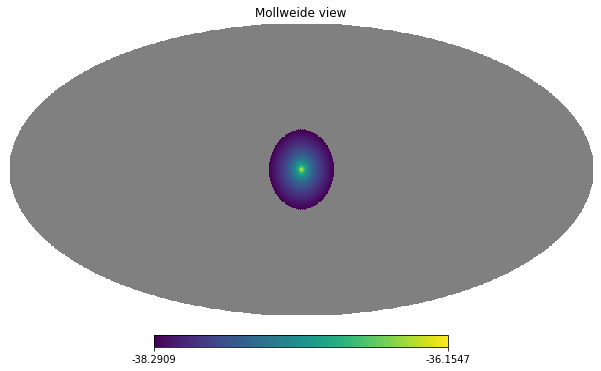

In [14]:
thetas, integral = get_dNdE()
make_image(integral)


In [459]:
print(np.mean(integral))


1.961834919216037e-07


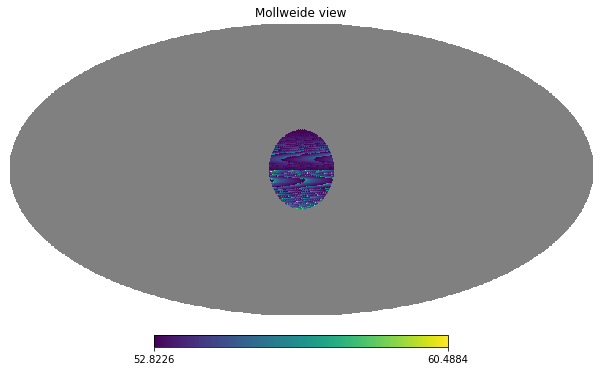

In [79]:
print(len(integral))

5910


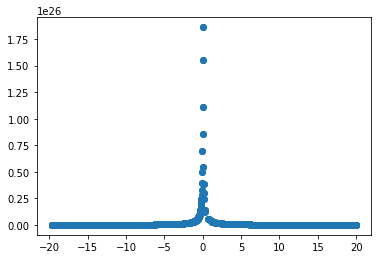

In [78]:
plt.scatter(thetas, integral)